In [1]:
from src.data import *

In [2]:
#Thermal Runaway Detection Pipeline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.base import BaseEstimator, ClassifierMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

#Configurations
DATA_DIR = "./data"
RESULTS_DIR = "./results"
WINDOW_SIZE = 100
STRIDE = 1
os.makedirs(RESULTS_DIR, exist_ok=True)

#Loading Data
def load_all_data(data_dir, window_size, stride):
    X_list, y_list = [], []
    for root, _, files in os.walk(data_dir):
        label = 0 if 'healthy' in root.lower() else 1
        for fname in files:
            if fname.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, fname))
                if df.isnull().values.any() or len(df) < window_size:
                    continue
                arr = df.values.astype(np.float32)
                for i in range(0, len(arr) - window_size + 1, stride):
                    X_list.append(arr[i:i + window_size])
                    y_list.append(label)
    X = np.array(X_list)
    y = np.array(y_list)
    print(f"Loaded: X.shape={X.shape}, y.shape={y.shape}")
    return X, y

#Scaling
def prepare_ml_data(X, y):
    n, T, F = X.shape
    X_flat = X.reshape(n, T * F)
    X_tr, X_te, y_tr, y_te = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42)
    scaler = RobustScaler()
    return scaler.fit_transform(X_tr), scaler.transform(X_te), y_tr, y_te

#Wrapper for Keras Classifier
class MyKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, batch_size=32, epochs=10, verbose=0):
        self.build_fn = build_fn
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model_ = None
        self._build_params = {}

    def set_params(self, **params):
        keras_keys = ["batch_size", "epochs", "verbose", "build_fn"]
        for key in list(params.keys()):
            if key not in keras_keys:
                self._build_params[key] = params.pop(key)
        for k in keras_keys:
            setattr(self, k, params.get(k, getattr(self, k, None)))
        return self

    def get_params(self, deep=True):
        return {
            "build_fn": self.build_fn,
            "batch_size": self.batch_size,
            "epochs": self.epochs,
            "verbose": self.verbose,
            **self._build_params
        }

    def fit(self, X, y):
        features = X.shape[-1]
        self.model_ = self.build_fn(features=features, **self._build_params)
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                        verbose=self.verbose, callbacks=[EarlyStopping(patience=2)])
        return self

    def predict(self, X):
        return (self.model_.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model_.predict(X)

#Deep Learning Models
def build_lstm(units=64, learning_rate=0.001, features=2):
    model = Sequential([
        LSTM(units, input_shape=(WINDOW_SIZE, features)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(filters=32, kernel_size=3, learning_rate=0.001, features=2):
    model = Sequential([
        Conv1D(filters, kernel_size, activation='relu', input_shape=(WINDOW_SIZE, features)),
        MaxPooling1D(2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Plotting
def save_all_confusion_matrices(conf_mats):
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    axs = axs.flatten()
    for ax, (name, cm) in zip(axs, conf_mats.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Healthy", "Runaway"],
                    yticklabels=["Healthy", "Runaway"], ax=ax)
        ax.set_title(f"Confusion: {name}")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "all_confusion_matrices.png"))
    plt.close()

def save_all_roc_curves(roc_data):
    fig, ax = plt.subplots(figsize=(10, 8))
    for name, (y_true, y_prob) in sorted(roc_data.items()):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_val = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_title("ROC Curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "all_roc_curves_sorted.png"))
    plt.close()

def save_auc_comparison(train_aucs, test_aucs):
    labels = list(train_aucs.keys())
    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, [train_aucs[l] for l in labels], width, label="Train AUC")
    plt.bar(x + width/2, [test_aucs[l] for l in labels], width, label="Test AUC")
    plt.xticks(x, labels, rotation=45)
    plt.ylabel("AUC")
    plt.title("Train vs Test AUC Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "train_vs_test_auc.png"))
    plt.close()

#Main Execution
if __name__ == "__main__":
    X, y = load_all_data(DATA_DIR, WINDOW_SIZE, STRIDE)
    _, _, FEATURES = X.shape
    X_tr_s, X_te_s, y_tr, y_te = prepare_ml_data(X, y)
    X_tr_dl, X_te_dl, y_tr_dl, y_te_dl = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    summary, confusion_matrices, roc_curves = [], {}, {}
    train_auc, test_auc = {}, {}
    best_params_all = {}

    #Classical Models with GridSearchCV
    classical_defs = {
        "RandomForest": (RandomForestClassifier(), {"n_estimators": [100, 200]}),
        "SVM": (SVC(probability=True), {"C": [0.1, 1, 10], "gamma": ["scale"], "kernel": ["rbf"]}),
        "GB": (GradientBoostingClassifier(), {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]})
    }

    train, test = process_data(X, y)
    for name, (model, grid) in classical_defs.items():
        gs = GridSearchCV(model, grid, cv=3, scoring="roc_auc", n_jobs=-1)
        gs.fit(train.X_scaled, train.y) # gs.fit(X_tr_s, y_tr)
        best = gs.best_estimator_
        print(f"🔍 Best {name} params:", gs.best_params_)
        best_params_all[name] = gs.best_params_

        y_pred = best.predict(test.X_scaled) # best.predict(X_te_s)
        y_prob = best.predict_proba(test.X_scaled)[:,1] # best.predict_proba(X_te_s)[:,1]
        cm = confusion_matrix(test.y, y_pred) # confusion_matrix(y_te, y_pred)
        confusion_matrices[name] = cm
        roc_curves[name] = (test.y, y_prob) # (y_te, y_prob)
        train_auc[name] = roc_auc_score(train.y, best.predict_proba(train.X_scaled)[:,1]) # roc_auc_score(y_tr, best.predict_proba(X_tr_s)[:,1])
        test_auc[name] = roc_auc_score(test.y, y_prob) # roc_auc_score(y_te, y_prob)

        df = pd.DataFrame(classification_report(y_te, y_pred, output_dict=True)).transpose(); df['model'] = name
        summary.append(df)
    
    #Deep Learning Models with GridSearchCV
    deep_defs = {
        "LSTM": (build_lstm, {
            "units": [32, 64],
            "learning_rate": [0.001, 0.0005],
            "epochs": [10],
            "batch_size": [32]
        }),
        "CNN": (build_cnn, {
            "filters": [16, 32],
            "kernel_size": [3],
            "learning_rate": [0.001],
            "epochs": [10],
            "batch_size": [32]
        })
    }

    for name, (builder, grid) in deep_defs.items():
        keras_clf = MyKerasClassifier(build_fn=builder)
        gs = GridSearchCV(keras_clf, grid, cv=3, scoring="roc_auc", n_jobs=1)
        gs.fit(train.X, train.y) # gs.fit(X_tr_dl, y_tr_dl)

        print(f"🔍 Best {name} params:", gs.best_params_)
        best_params_all[name] = gs.best_params_
        best_dl = gs.best_estimator_

        y_pred = best_dl.predict(test.X) # best_dl.predict(X_te_dl)
        y_prob = best_dl.predict_proba(test.X) # best_dl.predict_proba(X_te_dl)
        confusion_matrices[name] = confusion_matrix(test.y, y_pred) # confusion_matrix(y_te_dl, y_pred)
        roc_curves[name] = (test.y, y_prob) # (y_te_dl, y_prob)
        train_auc[name] = roc_auc_score(train.y, best_dl.predict_proba(train.X)) # roc_auc_score(y_tr_dl, best_dl.predict_proba(X_tr_dl))
        test_auc[name] = roc_auc_score(test.y, y_prob) # roc_auc_score(y_te_dl, y_prob)

        df = pd.DataFrame(classification_report(test.y, y_pred, output_dict=True)).transpose() # pd.DataFrame(classification_report(y_te_dl, y_pred, output_dict=True)).transpose()
        df['model'] = name
        summary.append(df)

    #Ensemble Models
    voting = VotingClassifier(estimators=[(k, v) for k, (v, _) in classical_defs.items()], voting='soft')
    voting.fit(X_tr_s, y_tr)
    y_prob = voting.predict_proba(X_te_s)[:,1]
    y_pred = voting.predict(X_te_s)
    confusion_matrices["Voting"] = confusion_matrix(y_te, y_pred)
    roc_curves["Voting"] = (y_te, y_prob)
    train_auc["Voting"] = roc_auc_score(y_tr, voting.predict_proba(X_tr_s)[:,1])
    test_auc["Voting"] = roc_auc_score(y_te, y_prob)
    df = pd.DataFrame(classification_report(y_te, y_pred, output_dict=True)).transpose(); df['model'] = "Voting"
    summary.append(df)

    stacking = StackingClassifier(estimators=[(k, v) for k, (v, _) in classical_defs.items()],
                                   final_estimator=LogisticRegression())
    stacking.fit(X_tr_s, y_tr)
    y_prob = stacking.predict_proba(X_te_s)[:,1]
    y_pred = stacking.predict(X_te_s)
    confusion_matrices["Stacking"] = confusion_matrix(y_te, y_pred)
    roc_curves["Stacking"] = (y_te, y_prob)
    train_auc["Stacking"] = roc_auc_score(y_tr, stacking.predict_proba(X_tr_s)[:,1])
    test_auc["Stacking"] = roc_auc_score(y_te, y_prob)
    df = pd.DataFrame(classification_report(y_te, y_pred, output_dict=True)).transpose(); df['model'] = "Stacking"
    summary.append(df)

    #Save metrics and figures
    pd.concat(summary).to_csv(os.path.join(RESULTS_DIR, "summary_metrics.csv"), index=False)
    save_all_confusion_matrices(confusion_matrices)
    save_all_roc_curves(roc_curves)
    save_auc_comparison(train_auc, test_auc)
    print("\n✅ Finished! All metrics and figures saved to:", RESULTS_DIR)


Loaded: X.shape=(34149, 100, 2), y.shape=(34149,)
🔍 Best RandomForest params: {'n_estimators': 200}

✅ Finished! All metrics and figures saved to: ./results


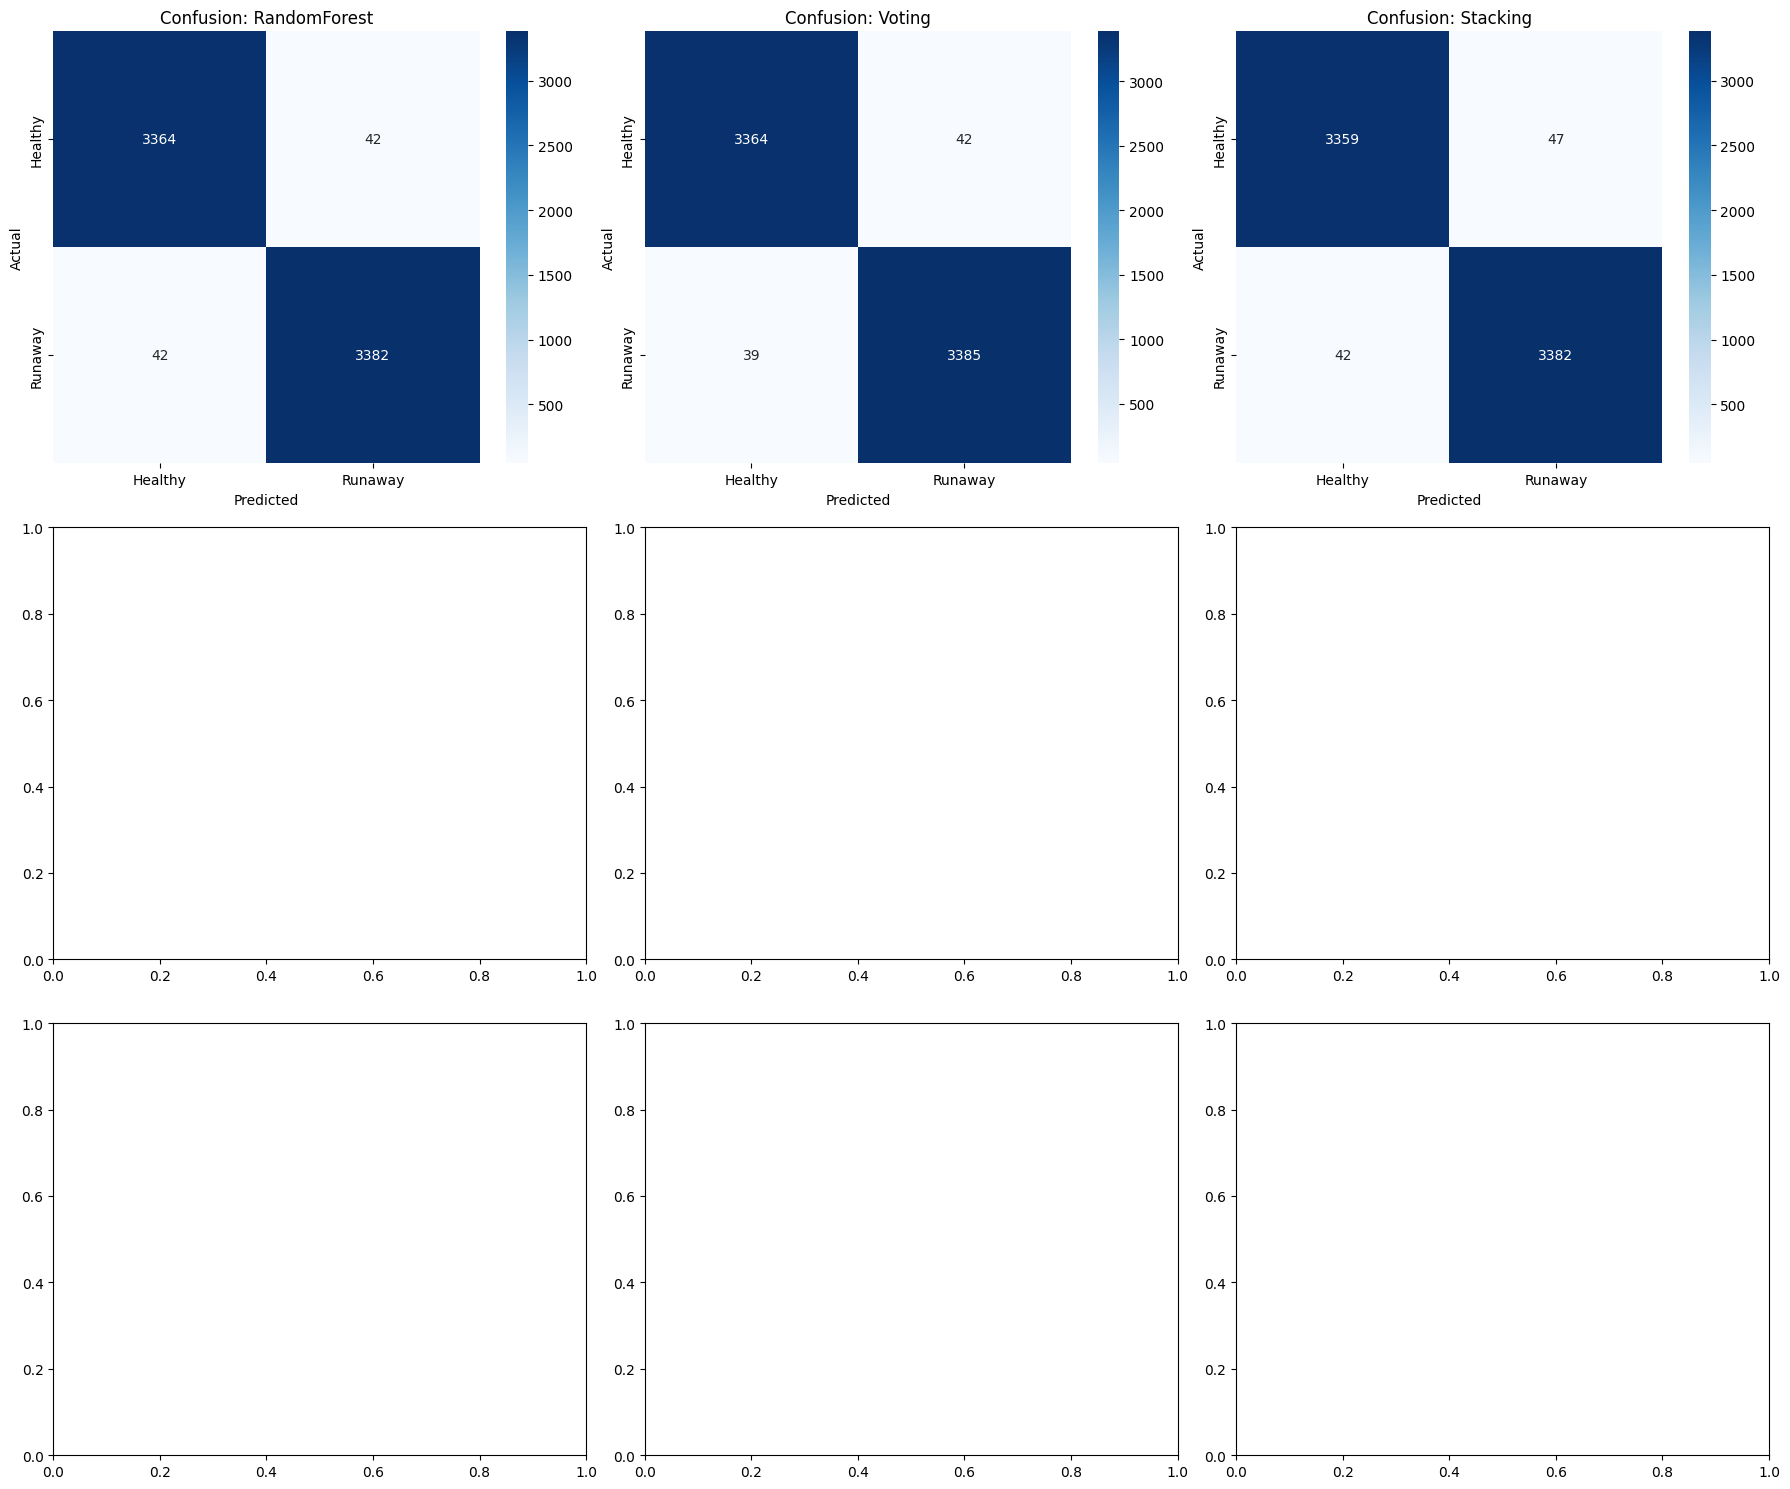

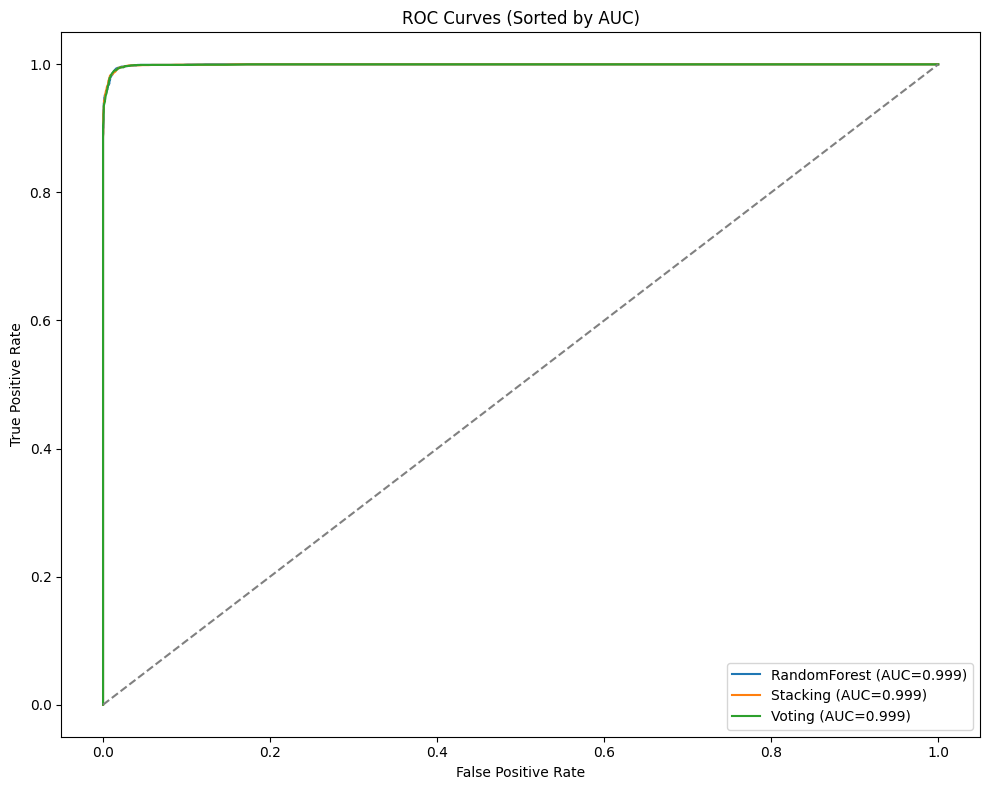

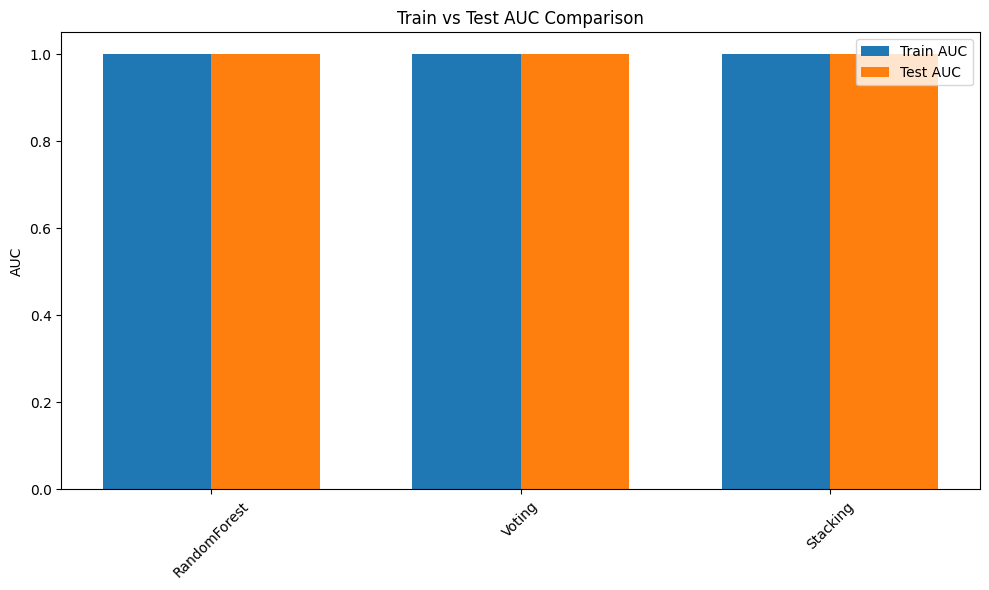

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

#Plotting Confusion Matrices
fig, axs = plt.subplots(3, 3, figsize=(18, 15))
axs = axs.flatten()
for ax, (name, cm) in zip(axs, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Healthy", "Runaway"],
                yticklabels=["Healthy", "Runaway"], ax=ax)
    ax.set_title(f"Confusion: {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

#ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))
sorted_roc = sorted(roc_curves.items(), key=lambda x: auc(*roc_curve(x[1][0], x[1][1])[:2]), reverse=True)
for name, (y_true, y_prob) in sorted_roc:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
ax.plot([0, 1], [0, 1], '--', color='gray')
ax.set_title("ROC Curves (Sorted by AUC)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.tight_layout()
plt.show()

#Train vs Test AUC Comparison
labels = list(train_auc.keys())
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10,6))
plt.bar(x - width/2, [train_auc[k] for k in labels], width, label="Train AUC")
plt.bar(x + width/2, [test_auc[k] for k in labels], width, label="Test AUC")
plt.xticks(x, labels, rotation=45)
plt.ylabel("AUC")
plt.title("Train vs Test AUC Comparison")
plt.legend()
plt.tight_layout()
plt.show()
